# Inertial Measurement Unit (IMU)

Kevin J. Walchko

12 July 2017

---

IMUs are key sensors in Inertial Navigation Systems (INS). INS is key for aircraft, ships, cruise missiles, ICBMs, etc to travel long distances and arrive at a location where we want them. Although the mathematical equations behind an INS is a little complex, the sensors feeding an INS need to be calibrated in order to get good results. Today, a lot of devices have IMU's built into them. The IMU we will use is actually one for a cell phone and costs around $15. 

When I was a grad student at UF, I was developing an INS for a robotic system. I was given a MEMS IMU which had a worse performance than the one we are using today. My IMU cost around $5000 back in the mid-to-late 1990's.

## References

- [Wikipedia MEMS](https://en.wikipedia.org/wiki/Microelectromechanical_systems)
- [Simple Calibration Routine](https://github.com/kriswiner/MPU6050/wiki/Simple-and-Effective-Magnetometer-Calibration)
- [Calibration Routine](http://www.sensorsmag.com/components/compensating-for-tilt-hard-iron-and-soft-iron-effects)
- [Hard/Soft Iron Effects](https://www.phidgets.com/docs/Magnetometer_Primer)
- [Wikipedia: Earth's magnetic field](https://en.wikipedia.org/wiki/Earth%27s_magnetic_field)
- [NASA: Earth's Pole Reversal](https://www.nasa.gov/topics/earth/features/2012-poleReversal.html)
- [Wikipedia: Tesla (unit)](https://en.wikipedia.org/wiki/Tesla_(unit))
- [C version](https://github.com/TobiasSimon/MadgwickTests/blob/master/MadgwickAHRS.c)
- [Low Cost Inertial Navigation](https://walchko.github.io/Publications/walchko-MS-EE.pdf)

## Setup

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
from __future__ import division
import numpy as np
from the_collector.bagit import BagReader
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import pyplot as plt
from math import sin, cos, atan2, pi, sqrt, asin
from math import radians as deg2rad
from math import degrees as rad2deg
# import cv2

# Navigation

Ultimately we would like our robots to be able to move autonomously from one location to another. A commonly used method is via an Inertial Navigation System (INS).

<img src="pics/ins-flow.png" width="700px">

<img src="pics/world-frames.png" width="500px">

The INS is generally composed of a couple of sensors, the primary being an inertial measurement unit (IMU). An IMU is composed of:

- Accelerometers - measures Earth's gravity field
- Gyroscopes - measures the rotation of the sensor
- Magnetometer - measures the Earth's magnetic field

Between these 3 sensors, we can get a majority of everything we need to navigate. Now the INS would use an Extended Kalman Filter with these sensors to continously estimate the robot's states: position, velocity and orientation.

![](pics/kf.png)

The dynamical equations for a very simple robot (actually a point mass) are:

$$
\begin{bmatrix}
  \dot V^e \\
  \dot P^e
\end{bmatrix} = 
\begin{bmatrix}
  -2 \Omega^e_{ie} & -\Omega^e_{ie}\Omega^e_{ie} \\
  I & 0
\end{bmatrix}
\begin{bmatrix}
  V^e \\
  P^e
\end{bmatrix} +
\begin{bmatrix}
  R^e_c & R^e_b \\
  0 & 0
\end{bmatrix}
\begin{bmatrix}
  g^c_{SHC} \\
  S^b
\end{bmatrix}
$$

where $g^c_{SHC}$ is the gravity model of the Earth, $S^b$ are the accelerometer measurements, $R$ is a rotation matrix feed by the gyros, and $\Omega^e_{ie}$ is the rotation rate of the Earth. These are the basic equations for an INS. Generally, you would augment them (make them more complex) for your robot's specific situation. 

Our Roomba has an IMU on it, so let's talk about the IMU some more.

# NXP IMU

![](pics/imu.jpg)

Our inertial measurement unit (IMU) contains 2 main chips:

### FXOS8700 3-Axis Accelerometer/Magnetometer

- ±2 g/±4 g/±8 g adjustable acceleration range
- ±1200 µT magnetic sensor range
- Output data rates (ODR) from 1.563 Hz to 800 Hz
- 14-bit ADC resolution for acceleration measurements
- 16-bit ADC resolution for magnetic measurements

### FXAS21002 3-Axis Gyroscope

- ±250/500/1000/2000°/s configurable range
- Output Data Rates (ODR) from 12.5 to 800 Hz
- 16-bit digital output resolution

# Micoelectromechanical Systems (MEMS)

MEMS is the technology of microscopic devices, particularly those with moving parts. It merges at the nano-scale into nanoelectromechanical systems (NEMS) and nanotechnology. MEMS are also referred to as micromachines in Japan, or micro systems technology (MST) in Europe. Basically, using technology for microprocessor production, companies are able to produce microscopic mechanical devices.

Our Inertial Measurement Unit is capable of measuring acceleration and the magnetic field of the Earth. Shown below, NXP produced a small mechanical device. Basically, as gravity pulls on the proof mass, the capacitance of C1 and C2 changes. When properly calibrated, the sensor is able to determine the amount of gravity from the capacitance change.

![How it works.](pics/mems-works.jpg)

Below shows what it looks like under an electron microscope.

![Viewed under an electron microscope.](pics/mems-microscope.jpg)

Here we will take sensor measurements and determine sensor biases to properly calibrate the sensor.

# Accelerometers

For the next series of images, imagine a gross simpification of the above discussion. A proof mass is magically suspended inside a box. The walls of the box are able to measure the amount of force applied to them. The proof mass will only displace from the center under the influence of an external acceleration.

![](pics/right_hand_axes.jpg)

Given a righthand coordinate system (e.g., standard cartesian coordinate system), the sensors measure acceleration as follows:

![](pics/center.png)

No gravity or acceleration acting on the device. Probably this is in space far from any celestial bodies or the device is in free fall (terminal velocity).

![](pics/x-acceleration.png)

Now the device is accelerating in the positive x-direction with no gravity present. Notice how the proof mass is being pulled by gravity and pressing against the negative x-axis? Thus the IMU reads the reaction (equal and opposite) of what is happening.

![](pics/gravity.png)

Just like before, there is only one acceleration acting on the device, gravity, and we measure an acceleration in the -Z direction. Typically people talk in terms of g's, this is mainly to stay away from the annoying issue of SI units ($9.81 m/sec^2$) or imperial units ($32 ft/sec^2$).

![](pics/xz-acceleration.png)

Finally, we have oriented our device $45^\circ$ up, and gravity is forcing the mass equally on the -x and -z axes.

## Accel Calibration

Manufactures try to produce sensors that perform well, but when you are making millions of them and the lowest cost is a critical factor in determining if someone will buy it, your sensor won't be perfect. Typically, you want to run the accels through a variety of static tests, where you orient them differently under in a 1G environment.

**WARNING:** To avoid confusion. Our accelerometer reports the G loading. So when it is sitting flat on a table and the gravity vector is $[0,0,-1]$, it will report $[0,0,1]$ because it is 1G.

# Gyroscopes

MEMS gyroscopes contain a pair of masses that are driven to oscillate with equal amplitude but in opposite directions. When rotated, the Coriolis force creates an orthogonal vibration that can be sensed by a variety of mechanisms.

$$
F = 2 M v \times \Omega
$$

where $F$ is the force, $M$ is the mass, $v$ is the velocity of the mass, and $\Omega$ is the angular velocity.

# Magnetometers

## Earth's Magnetic Field

The intensity of the field is often measured in gauss (G), but is generally reported in nanoteslas (nT), with 1 G = 100,000 nT. A nanotesla is also referred to as a gamma ($\gamma$). The tesla is the SI unit of the Magnetic field, B. The Earth's field ranges between approximately 25,000 and 65,000 nT (0.25–0.65 G or 25-65 $\mu$T). By comparison, a strong refrigerator magnet has a field of about 10,000,000 nanoteslas (100 G).

| Prefix | Symbol | Decimal   |
|--------|--------|-----------|
| milli  | m      | $10^{-3}$ |
| micro  | $\mu$  | $10^{-6}$ |
| nano   | n      | $10^{-9}$ |

## Geographical Variation of the Field

![](pics/world_field_map.jpg)


## Temporal Variation of the Field

The Earth's magnetic field is always changing and often change every 200k - 300k years.

![](pics/earth_magnetic_field.gif)

## Noise

### Hard Iron Interference

So called hard iron interference is caused by static magnetic fields associated with the enviornment. For example, this could include any minor (or major) magnetism in the metal chassis or frame of a vehicle, any actual magnets such as speakers, etc... This interference pattern is unique to the environment but is constant. If you have your compass in an enclosure that is held together with metal screws, these relatively small amounts of ferromagnetic material can cause issues. If we consider the magnetic data circle, hard iron interference has the effect of shifting the entire circle away from the origin by some amount. The amount is dependent on any number of different factors and can be very large. The important part is that this shift is the same for all points in time so it can be calibrated out very easily with a numeric offset which is taken care of by the calibration process


To compensate and recenter, for each axis (x,y,z), we will calculate the mean offset ($\alpha$):

$$
\alpha_x = \frac{x_{max} + x_{min}}{2} \\
mag_{corrected} = mag_{raw} - \alpha_x
$$

### Soft Iron Interference

Soft iron interference is caused by distortion of the Earth's magnetic field due to materials in the environment. Think of it like electricity - the magnetic field is looking for the easiest path to get to where it is going. Since magnetic fields can flow more easily through ferromagnetic materials than air, more of the field will flow through the ferromagnetic material than you would expect if it were just air. This distortion effect causes the magnetic field lines to be bent sometimes quite a bit. Note that unlike hard iron interference which is the result of materials which actually have a magnetic field of their own, soft iron interference is caused by non-magnetic materials distorting the Earth's magnetic field. This type of interference has a squishing effect on the magnetic data circle turning it into more of an ellipsoid shape. The distortion in this case depends on the direction that the compass is facing. Because of this, the distortion cannot be calibrated out with a simple offset, more complicated math will still let the compass account for this type of interference though.

# Cell Phones

The coordinate systems for cell phones are strange. They don't follow normal aerospace coordinate system definitions for doing INS. This is probably because CompSci types don't understand the math and only think about GUI programming where the axes are typically oriented different. 

Some IMUs, if you spend a little more money, come with Kalman Filters built into them. Understanding how they are set up can be confusing for someone with an aerospace/INS background and not an Andriod/Windows background. Any ways, typical definitions for cell phones IMUs are:

![](pics/axis_device.png)

![](pics/Yaw-Pitch-Roll-Slate-Win8.png)

Our IMU does not have this issue, but in the future, as cell phone/laptop/tablet IMU become cheaper and more common, it is good information to understand becuase you may be using one on your robot.

# Various Function

This section holds various functions to format, display, or whatever. These are used in the following sections without much of an explaination. The code and comments are below if you really want to know.

In [3]:
def normalize(x, y, z):
    """Return a unit vector"""
    norm = sqrt(x * x + y * y + z * z)
    if norm > 0.0:  # why did I do this?
        inorm = 1/norm  # why did I do this?
        x *= inorm
        y *= inorm
        z *= inorm
    else:
        raise Exception('division by zero: {} {} {}'.format(x, y, z))
    return (x, y, z)

In [4]:
def plotArray(data, dt=None, title=None):
    """
    Plots the x, y, and z components of a sensor.
    
    In:
        title - what you want to name something
        [[x,y,z],[x,y,z],[x,y,z], ...]
    Out:
        None
    """
#     x = []
#     y = []
#     z = []
#     for d in data:
#         x.append(d[0])
#         y.append(d[1])
#         z.append(d[2])

    if dt is None:
        dt = range(len(data))
        
    plt.subplot(3,1,1)
    plt.plot(dt, [x[0] for x in data])
    plt.ylabel('x')
    plt.grid(True)
    if title:
        plt.title(title)
    
    plt.subplot(3,1,2)
    plt.plot(dt, [x[1] for x in data])
    plt.ylabel('y')
    plt.grid(True)
    
    plt.subplot(3,1,3)
    plt.plot(dt, [x[2] for x in data])
    plt.ylabel('z')
    plt.grid(True)

In [5]:
def getOrientation(accel, mag, deg=True):
    ax, ay, az = normalize(*accel)
    mx, my, mz = normalize(*mag)
    
    roll = atan2(ay, az)
    pitch = atan2(-ax, ay*sin(roll)+az*cos(roll))

    heading = atan2(
        mz*sin(roll) - my*cos(roll),
        mx*cos(pitch) + my*sin(pitch)*sin(roll) + mz*sin(pitch)*cos(roll)
    )

    if deg:
        roll *= 180/pi
        pitch *= 180/pi
        heading *= 180/pi

        heading = heading if heading >= 0.0 else 360 + heading
        heading = heading if heading <= 360 else heading - 360
    else:
        heading = heading if heading >= 0.0 else 2*pi + heading
        heading = heading if heading <= 2*pi else heading - 2*pi

    return (roll, pitch, heading)

In [6]:
def apply_calibration(data, bias):
    """
    Given the data and the bias, correct the data 
    """
    c_data = []
    for d in data:
        t = []
        for i in [0,1,2]:
            t.append(d[i]-bias[i])
        c_data.append(t)
            
    return c_data

In [7]:
def split_xyz(data):
    """
    Break out the x, y, and z into it's own array for plotting
    """
    xx = []
    yy = []
    zz = []
    for v in data:
        xx.append(v[0])
        yy.append(v[1])
        zz.append(v[2])
    return xx, yy, zz

def plotMagnetometer3D(data, title=None):
    x,y,z = split_xyz(data)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    ax.plot(x, y, z, '.b');
    ax.set_xlabel('$\mu$T')
    ax.set_ylabel('$\mu$T')
    ax.set_zlabel('$\mu$T')
    if title:
        plt.title(title);

def plotMagnetometer(data, title=None):
    x,y,z = split_xyz(data)
    plt.plot(x,y,'.b', x,z,'.r', z,y, '.g')
    plt.xlabel('$\mu$T')
    plt.ylabel('$\mu$T')
    plt.grid(True);
    plt.legend(['x', 'y', 'z'])
    if title:
        plt.title(title);

In [8]:
# def split(data):
#     """Separates the data from the timestamp for each sample"""
#     ret = []
#     rdt = []
#     start = data[0][1]
#     for d, ts in data:
#         ret.append(d)
#         rdt.append(ts - start) # produce a relative time timeline starting from 0 seconds
#     return ret, rdt

# Get Sensor Data

First lets spin around the imu and grab lots of data in different orientations. This is done on a high precision "lazy susan" from [Walmart](https://www.walmart.com/ip/Mainstays-Lazy-Susan-Bamboo/21950041).

![](pics/lazy-susan.jpg)

Here are are collecting the accel, mag, gyro, and video data. Remeber, at each time step, `bagit` appends a timestamp to each of these data samples. We will have to pull those off so we can work with the data and plot it correctly.

In [9]:
# IMU x-dir 225 deg on iphone
bag = BagReader()
cal = bag.read('data-still.bag')

# let's list the keys and make it look pretty
print('Bag keys:')
print('-'*30)
for k in cal.keys():
    # goddam python3 and strings!
    print('  {:7}: {}'.format(k.decode('ASCII'), len(cal[k])))

Bag keys:
------------------------------
  mag    : 500
  accel  : 500
  grav   : 500
  lidar  : 500


In [10]:
# print(data[b'grav'.decode()])
mm=[[1,2,3],[4,5,6],[6,7,8]]
[x[0] for x in mm]
import the_collector
the_collector.__version__

'0.5.1'

# Magnetometer

First let's take a look at the raw data.

**Note:** when the data was taken, the system was pointing at 42 degrees

In [11]:
# remember, each data sample has a time stamp applied
# for plotting, let's separate the timestamp (x-axis) and the data (y-axis)
# accel, adt = split(cal[b'accel'])
# mag, mdt = split(cal[b'mag'])
# gyro, gdt = split(cal[b'grav'])
# lidar, ldt = split(cal[b'lidar'])

accel = cal[b'accel']
mag = cal[b'mag']
gyro = cal[b'grav']
lidar = cal[b'lidar']


for i in range(len(lidar)):
    for j in range(len(lidar[i])):
        lidar[i][j] /= 1000  # convert to meters
        
max(lidar[1])

4.167

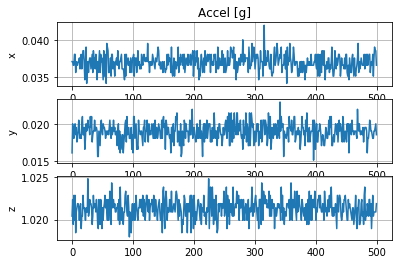

In [13]:
plotArray(accel, title='Accel [g]')

Again, this is sitting flat on a table, the z-axis is pointing up and gravity is pointing down. Therefore we should see 1G or $[0,0,1]$. Do not get confused and expect to see -1 in the z-axis.

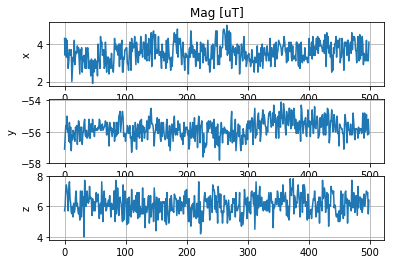

In [14]:
# magnetometer measures Earth's magnetic field
plotArray(mag, title='Mag [uT]')

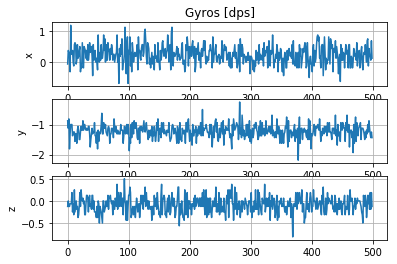

In [15]:
# gyros measure the spin rate (rads/sec or degrees/sec (dps)) of the sensor
plotArray(gyro, title='Gyros [dps]')

Ok, so I spun the sensor on a lazy susan (orderve platter). The x (roll) and y (pitch) results are due to the fact it is cheap and not made for high precision testing and measurements. 

Notice the z-axis results (yaw). This is equal to the heading or compass direction and measured in degrees per second (dps). Looking at the measurements, I was not very consistent in my rotational speed ... honestly I didn't even think about trying to stay consistent. But you can see I turned in one direction for a while (positive rate) and then I move it back (negative rate). 

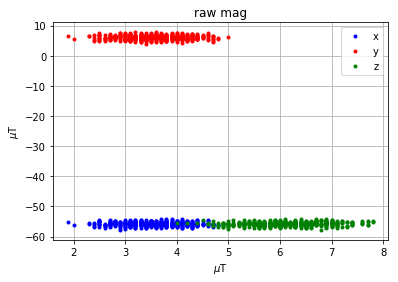

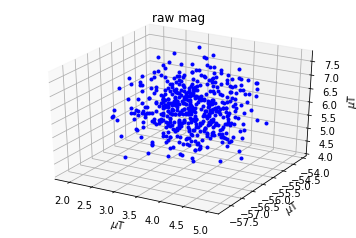

In [16]:
# now, ideally these should be an ellipsoid centered around 0.0
# but they aren't ... need to fix the bias (offset)
plotMagnetometer(mag, 'raw mag')
plotMagnetometer3D(mag, 'raw mag')

## Magnetometer Calibration

To compensate and recenter, for each axis (x,y,z), we will calculate the mean offset ($\alpha$):

$$
\alpha_x = \frac{x_{max} + x_{min}}{2} \\
mag_{corrected} = mag_{raw} - \alpha_x
$$

In [29]:
def find_mag_calibration(mag):
    """
    Go through the raw data and find the max/min for x, y, z
    """
    max_m = [-1000]*3
    min_m = [1000]*3
    for m in mag:
        for i in range(3):
            max_m[i] = m[i] if m[i] > max_m[i] else max_m[i]
            min_m[i] = m[i] if m[i] < min_m[i] else min_m[i]
    bias = [0]*3
    for i in range(3):
        bias[i] = (max_m[i] + min_m[i])/2
    return bias

In [30]:
# so let's find the bias needed to correct the imu
bias = find_mag_calibration(mag)
print('bias', bias)

bias [3.45, -55.95, 5.9]


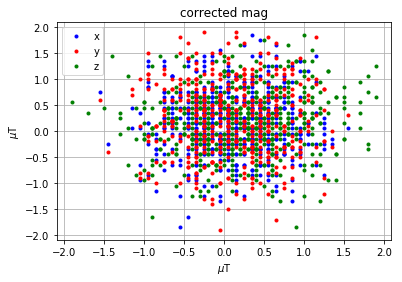

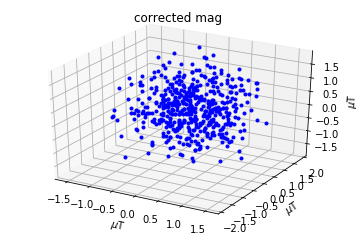

In [19]:
# now the data should be nicely centered around (0,0,0)
cm = apply_calibration(mag, bias)
plotMagnetometer(cm, 'corrected mag')
plotMagnetometer3D(cm, 'corrected mag')

Notice how the results are centered around zero and look nicely uniform. Remeber, this was very simplistically and without the use of high quality test/measurement equipment, so I wouldn't try to navigate a satellite with this system. However, for our purposes it is fine.

Now using this bias, we should get better performance when reading the compass.

# Accelerometer Calibration

We are not going to do much with the acceleromer or gyro data. Properly calibrating these is much more complex and little biases lead to large errors over time. By comparison, the magnetometers are really simple. 

Generally, our accelerometer model is:

$$
\begin{bmatrix}
  a_x \\
  a_y \\
  a_z
\end{bmatrix}_{meas} = 
\begin{bmatrix}
  1 & M_{xy} & M_{xz} \\
  M_{yx} & 1 & M_{yz} \\
  M_{zx} & M_{zy} & 1
\end{bmatrix} 
\begin{bmatrix}
  s_x & 0 & 0 \\
  0 & s_y & 0 \\
  0 & 0 & s_z
\end{bmatrix}
\begin{bmatrix}
  a_x \\
  a_y \\
  a_z
\end{bmatrix}_{inertial}+
\begin{bmatrix}
  bias_x \\
  bias_y \\
  bias_z
\end{bmatrix}
$$

where $M_{xyz}$ are the axis coupling terms which come from small error due to the accelerometers not being orthogonal, $s_{xyz}$ are scaling errors which arise from error in reading the true value of the gravity, $a_{meas}$ are the noisy measured acceration values, and $a_{inertial}$ are the real clean acceleration terms. You have to go through a complicated calibration process to determine what these values really are ... it is  a lot of work.

We are going to do a very simple calibration on our accelerometer. Since our system is always in one orientation, we know gravity is always facing down. Therefore, we are just going to take the mean value and subtract it from [0, 0, 1].

Acceleration bias: 0.0370 0.0189 0.0213


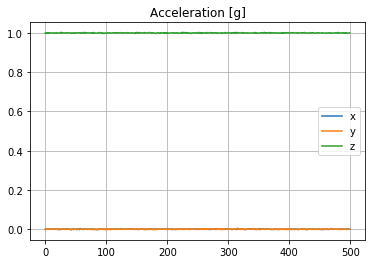

In [46]:
def find_accel_calibration(a, ref):
    # we expect to see [0,0,1], so we will find the average offset from
    # that value and use it as the bias ... this is far from the best
    # way to do this in the real world.
    # x,y,z = split_xyz(a)
    xx = np.mean([x[0] for x in a])
    yy = np.mean([x[1] for x in a])
    zz = np.mean([x[2] for x in a])
    
#     print(xx,yy,zz,ref)
#     print(a)
    return xx - ref[0], yy - ref[1], zz - ref[2]

a_bias = find_accel_calibration(accel, [0,0,1])
print('Acceleration bias: {:.4f} {:.4f} {:.4f}'.format(*a_bias))

ca = apply_calibration(accel, a_bias)

plt.plot([x[0] for x in ca], label='x')
plt.plot([x[1] for x in ca], label='y')
plt.plot([x[2] for x in ca], label='z')
plt.title('Acceleration [g]')
plt.legend()
plt.grid(True);

In [33]:
np.mean([x[0] for x in accel])

0.036994304

# Check Calibration

So lets take the calibrated sensor readings now and display the heading (yaw) of the system.

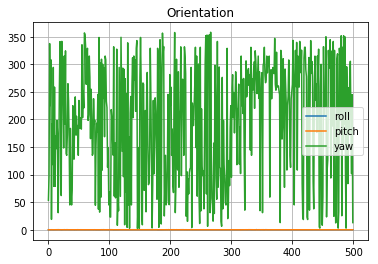

In [21]:
# r,p,y = getOrientation(accel, mag, deg=True)
orient = []
for a, m in zip(ca, cm):
    o = getOrientation(a, m, deg=True)
    orient.append(o)

# split out the data
plt.plot([x[0] for x in orient], label='roll')
plt.plot([x[1] for x in orient], label='pitch')
plt.plot([x[2] for x in orient], label='yaw')
plt.legend()
plt.title('Orientation')
plt.grid(True);

Ok, so you weren't there to see what I did, so you have no idea what happened. Luckily I took video from the camera while I conducted this little experement.

# Video

Since our bag file contains video in addition to  sensor values, let's pull the video out. Below is a simple MPEG4 writer we have seen before. Since jupyter is not great at showing videos, we are going to save the image to an mpg4 and then play the video back in the notebook.

In [22]:
# # simple function to save a video
# import platform
# def videoWrite(frames, fname='out.mp4'):
#     frame_height, frame_width, _ = frames[0].shape
    
#     # pick a good encoder for the current OS
#     sys = platform.system()
#     if sys in ['Darwin']:
#         fourcc = 'avc1'
#     else:
#         fourcc = 'mjpg'
        
#     out = cv2.VideoWriter(
#         fname,
#         cv2.VideoWriter_fourcc(*fourcc), 
#         30, 
#         (frame_width,frame_height))
#     for frame in frames:
#         out.write(frame)
#     out.release()

In [ ]:
# frames = []
# for f, ts in cal['camera']:
#     frames.append(f)

# videoWrite(frames, 'sensor_data.mp4')

In [ ]:
# from IPython.display import HTML # need this for embedding a movie in an iframe
# HTML('<iframe src="sensor_data.mp4" frameborder="0" webkitallowfullscreen mozallowfullscreen allowfullscreen></iframe>')

So basically you can see me spinning it around in one direction and the reversing in the other direction. I don't start/stop in the same direction, but hopefully you can look at the heading in the above plot and track what is happening from the movie.

In [ ]:
# # here is just one frame ... I made the video small so it didn't take up much room
# f = frames[320]
# plt.imshow(f)
# plt.title(f.shape);


-----------

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" style="border-width:0" src="https://i.creativecommons.org/l/by-sa/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/">Creative Commons Attribution-ShareAlike 4.0 International License</a>.

In [ ]:
# lidar

In [ ]:
# theta = [i*2*pi/360 for i in range(360)]
# for pts in lidar:
#     plt.subplot(111, projection='polar')
#     plt.plot(theta, pts)
#     plt.grid(True)
#     plt.draw()
#     plt.pause(0.2)
#     plt.clf()

In [ ]:
# import matplotlib.animation as animation
# from matplotlib import rc
# from IPython.display import HTML

# rc('animation', html='html5')

# def update_line(num, scans, theta, line):
#     # scan = next(iterator)
# #     print(num)
#     scan = scans[num]
# #     offsets = np.array([(th, rng) for th, rng in zip(theta, scan)])
#     tmp = []
#     for th, rng in zip(theta, scan):
#         tmp.append((th,rng))
# #     print(tmp)
#     offsets = np.array(tmp)
#     line.set_offsets(offsets)
#     intens = np.array([meas for meas in scan])
#     line.set_array(intens)
#     return line,



# #DMAX = 4000
# # IMIN = 0
# # IMAX = 50

# dmax = 0
# for scan in lidar:
#     for d in scan:
#         dmax = d if d > dmax else dmax

# theta = [i*2*pi/360 for i in range(360)]

# # %matplotlib osx
# # %matplotlib agg

# fig = plt.figure()
# fig.suptitle('Range [m]')
# ax = plt.subplot(111, projection='polar')
# # line = ax.scatter([0, 0], [0, 0], s=5, c=[IMIN, IMAX], cmap=plt.cm.Greys_r, lw=0)
# line = ax.scatter([0, 0], [0, 0])
# ax.set_rmax(1.25*dmax)
# ax.grid(True)

# ani = animation.FuncAnimation(
#     fig,
#     update_line,
#     fargs=(lidar, theta, line),
#     interval=100,
#     frames=len(lidar),
#     blit=True)
# # HTML(ani.to_html5_video())

# # %matplotlib inline
# ani

In [ ]:
# ani.save('lidar.mp4')

In [ ]:
# dir(fig)

In [26]:
import matplotlib.animation as animation
from matplotlib import rc
from IPython.display import HTML

rc('animation', html='html5')

def plot_lidar_range(lidar, fname=None):
    """
    lidar - rangle data
    fname - file name to save mp4 to
    """
    def update_line(num, scans, theta, line):
        scan = scans[num]
        offsets = np.array([(th, rng) for th, rng in zip(theta, scan)])
        line.set_offsets(offsets)
        intens = np.array([meas for meas in scan])
        line.set_array(intens)
        return line,

    dmax = 0
    for scan in lidar:
        for d in scan:
            dmax = d if d > dmax else dmax

    theta = [i*2*pi/360 for i in range(360)]

    fig = plt.figure()
    fig.suptitle('Range [m]')
    ax = plt.subplot(111, projection='polar')
    line = ax.scatter([0, 0], [0, 0])
    ax.set_rmax(1.25*dmax)
    ax.grid(True)

    ani = animation.FuncAnimation(
        fig,
        update_line,
        fargs=(lidar, theta, line),
        interval=100,
        frames=len(lidar),
        blit=True)
    
    if fname:
        ani.save(fname)
        
    return ani

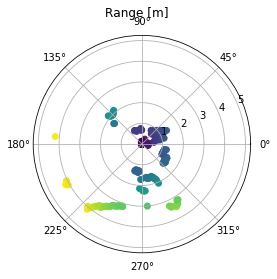

In [28]:
a=plot_lidar_range(lidar, 'lidar-still.mp4')

In [27]:
a